In [1]:
% load_ext autoreload
% aimport utils
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, timedelta
from utils import *
from sklearn.decomposition import PCA
import plotly.express as px

In [2]:
% autoreload 1
deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv',
           error_bad_lines=False)
cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv',
                   error_bad_lines=False)
#cases['FIPS'] = cases['FIPS'].astype('int')
day_cases = get_day_cases()
counties = pd.read_csv('https://raw.githubusercontent.com/Yu-Group/covid19-severity-prediction/master/data/county_data_abridged.csv',
                      error_bad_lines=False)
county_cases = pd.read_csv('https://raw.githubusercontent.com/Yu-Group/covid19-severity-prediction/master/data/county_level/processed/nytimes_infections/nytimes_infections.csv',
                          error_bad_lines=False)

In [3]:
death_keep = [col+'_deaths' if (col in cases.columns and col != 'FIPS') else col for col in deaths.columns]
cases_keep = [col+'_cases' for col in cases.columns[12:]]
cases_and_deaths = cases.merge(deaths, on='FIPS', suffixes=('_cases', '_deaths'))[death_keep+cases_keep]
renamer = lambda name: name if (type(name) != str or '/' in name or '_deaths' not in name) else name[:-7]
cases_and_deaths = cases_and_deaths.rename(columns=renamer)
cases_and_deaths.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,5/3/20_cases,5/4/20_cases,5/5/20_cases,5/6/20_cases,5/7/20_cases,5/8/20_cases,5/9/20_cases,5/10/20_cases,5/11/20_cases,5/12/20_cases
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,145,145,145,149,149,151,151,151,151,152
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,14,14,14,15,15,15,16,16,19,19
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,1808,1843,1924,1968,2031,2156,2173,2198,2256,2299
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,66,66,66,66,66,68,68,69,69,69


In [4]:
valid_territories = cases_and_deaths[(cases_and_deaths['Lat'] > 0) & ~np.isnan(cases_and_deaths['FIPS'])]
valid_territories.loc[:, 'FIPS'] = valid_territories['FIPS'].astype('int')
valid_counties = counties[~counties['countyFIPS'].isin(['City1', 'City2'])]
valid_counties.loc[:, 'countyFIPS'] = valid_counties['countyFIPS'].astype('int')

C:\Users\2000s\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [5]:
# MOST IMPORTANT TABLE
county_all = valid_counties.merge(valid_territories, left_on='countyFIPS', right_on='FIPS')
county_all = county_all.drop(columns=['Lat', 'Long_', 'Province_State', 'Country_Region', 'FIPS'])
#county_all.to_csv('county_info_cases_deaths.csv')

C:\Users\2000s\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


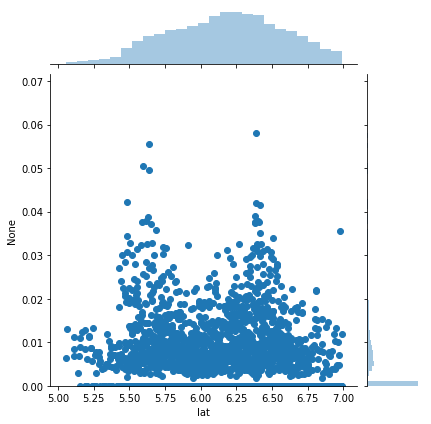

In [6]:
#sns.jointplot(county_all['lon'],
#              np.sqrt((county_all['4/20/20_cases'] / county_all['Population'])))
d = county_all[county_all['lat'] > 0]
sns.jointplot(np.sqrt(d['lat']),
                np.sqrt(d['5/8/20_deaths'] / d['Population']),
              )

plt.ylim(ymin=0)
plt.show()

In [7]:
def preprocess_counties(counties_df):
    # turn ordinal dates into useful dates
    counties_df = counties_df.iloc[:, 75:83].dropna().apply(lambda col: col.apply(lambda x: pd.Timestamp.fromordinal(int(x))))
    return counties_df

In [393]:
def moving_average(a, n=7, ndim=1) :
    """
    From https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
    """
    if ndim == 2:
        return moving_average_2d(a, n=n)
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def moving_average_2d(a, n=7):
    ret = np.cumsum(a, axis=1, dtype=float)
    ret[:, n:] = ret[:, n:] - ret[:, :-n]
    return ret[:, n - 1:] / n

def plot_feature_bins(df, colname, ylabel=None, num_bins=4,
                      stat='cases', smoothing=5, normalize=False,
                     quartiles=True, transformer=lambda x: x):
    indep_var = df[colname].astype('float')
    pops = df['PopTotalMale2017'] + df['PopTotalFemale2017']
    if normalize:
        indep_var /= pops
    valid_idxs = ~np.isnan(indep_var)
    indep_var = transformer(indep_var[valid_idxs])
    valid_df = df[valid_idxs]
    
    ivar_min, ivar_max = np.min(indep_var), np.max(indep_var)
    if quartiles:
        bins = [np.percentile(indep_var, 100/num_bins*i) for i in range(num_bins+1)]
    else:
        bins = np.linspace(ivar_min, ivar_max, num_bins+1)
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)
    for i in range(num_bins):
        binned_idxs = (bins[i] <= indep_var) & (indep_var < bins[i+1])
        binned = valid_df.loc[binned_idxs].filter(regex='_'+stat)
        pop = (valid_df['PopTotalMale2017'] + valid_df['PopTotalFemale2017'])[binned_idxs]
        if stat=='cases':
            #print(binned)
            dates = pd.to_datetime(binned.columns.str.replace(r'_cases', ''))
            binned = (np.array(binned) / pop[:, None]).mean(axis=0)
            binned = pd.Series(data=binned, index=dates)
        else:
            dates = pd.to_datetime(binned.columns.str.replace(r'_deaths', ''))
            binned = (np.array(binned) / pop[:, None]).mean(axis=0)
            binned = pd.Series(data=binned, index=dates)
        binned = binned.astype('float')
        y = np.diff(binned.values)
        x = binned.index[:-smoothing]
        y = moving_average(y, smoothing)
        sns.lineplot(x=x, y=y, ax=ax, label=str(100/num_bins*i) + '-' + str(100/num_bins*(i+1)))
    plt.xlabel('Time')
    if ylabel is None:
        ylabel = 'Cases' if stat=='cases' else 'Deaths'
    plt.setp(ax.get_xticklabels(), rotation=60)
    ax.legend()
    plt.legend(title = colname)
    plt.show()
    return bins
    
    
def find_peak(df, smoothness=2, stat='cases'):
    df = df.filter(regex='_' + stat)
    case_change_arr = np.diff(np.array(df), axis=1)
    smoothed_ccarr = moving_average(case_change_arr, n=smoothness, ndim=2)
    print(smoothed_ccarr.shape)
    peak_dates = df.columns[np.argmax(smoothed_ccarr, axis=1)+1].str.replace('_' + stat, '')
    return pd.to_datetime(peak_dates)

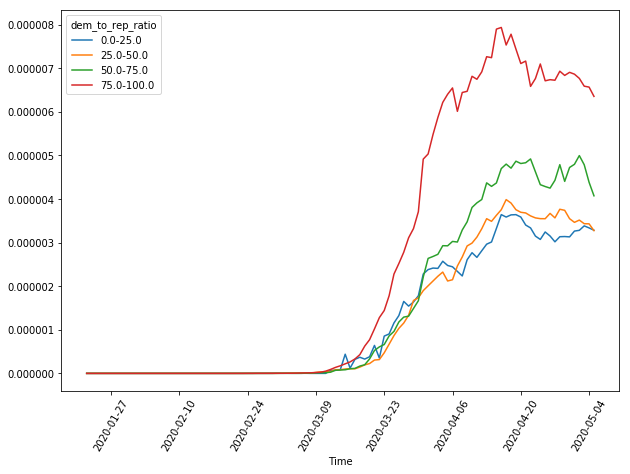

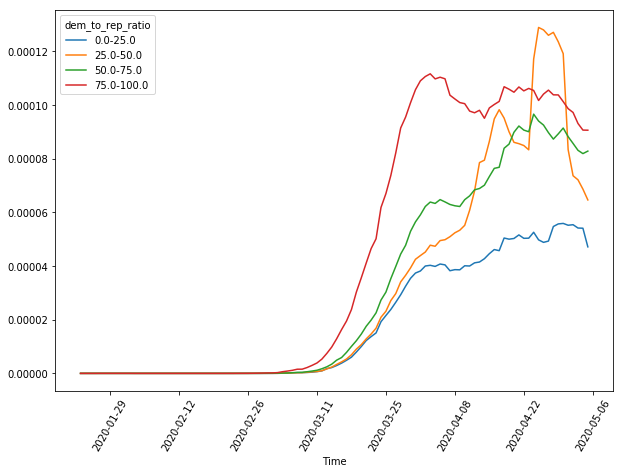

Bins1: [0.09176470588235294, 0.35278943934570794, 0.561785734636503, 0.9693554967396023, 22.229820011003696]
Bins2: [0.09176470588235294, 0.35278943934570794, 0.561785734636503, 0.9693554967396023, 22.229820011003696]


In [399]:
# cell to play around with!
#plot_feature_bins(has_both, 'PopTotalMale2017', stat='cases', smoothing=7, normalize=True)
bins1 = plot_feature_bins(has_both, 'dem_to_rep_ratio', stat='deaths',
                          smoothing=7, normalize=False)
bins2 = plot_feature_bins(has_both, 'dem_to_rep_ratio', stat='cases',
                          smoothing=7, normalize=False)
print('Bins1:', bins1)
print('Bins2:', bins2)

In [392]:
has_both[has_both['dem_to_rep_ratio'] > 1]

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,...,5/3/20_cases,5/4/20_cases,5/5/20_cases,5/6/20_cases,5/7/20_cases,5/8/20_cases,5/9/20_cases,5/10/20_cases,5/11/20_cases,5/12/20_cases
5,1011,1.0,11.0,Bullock,AL,Alabama,32.106336,-85.716804,32.116327,-85.701192,...,14,16,18,18,18,21,22,23,26,26
23,1047,1.0,47.0,Dallas,AL,Alabama,32.326702,-87.097675,32.408815,-87.034955,...,59,65,68,76,83,95,102,108,122,124
31,1063,1.0,63.0,Greene,AL,Alabama,32.865701,-87.948140,32.830505,-87.924000,...,58,61,61,64,67,70,70,70,73,73
32,1065,1.0,65.0,Hale,AL,Alabama,32.764902,-87.622198,32.775804,-87.626084,...,52,56,59,60,62,62,66,69,72,74
36,1073,1.0,73.0,Jefferson,AL,Alabama,33.563058,-86.890254,33.518601,-86.814688,...,969,992,1020,1048,1065,1094,1109,1121,1131,1153
42,1085,1.0,85.0,Lowndes,AL,Alabama,32.157807,-86.650036,32.162415,-86.618688,...,71,75,80,82,85,88,96,99,103,111
43,1087,1.0,87.0,Macon,AL,Alabama,32.393858,-85.695114,32.425739,-85.715007,...,40,40,41,42,43,44,47,47,49,51
45,1091,1.0,91.0,Marengo,AL,Alabama,32.251232,-87.778312,32.340479,-87.800648,...,58,66,68,68,73,76,77,80,83,89
50,1101,1.0,101.0,Montgomery,AL,Alabama,32.225380,-86.207102,32.346175,-86.243797,...,409,438,456,477,515,533,576,608,642,684
59,1119,1.0,119.0,Sumter,AL,Alabama,32.589619,-88.192063,32.574420,-88.232646,...,77,81,85,87,92,93,98,100,106,110


In [268]:
has_both.iloc[:5, 93:207]

,Population,1/22/20_deaths,1/23/20_deaths,1/24/20_deaths,1/25/20_deaths,1/26/20_deaths,1/27/20_deaths,1/28/20_deaths,1/29/20_deaths,1/30/20_deaths,...,5/4/20_deaths,5/5/20_deaths,5/6/20_deaths,5/7/20_deaths,5/8/20_deaths,5/9/20_deaths,5/10/20_deaths,5/11/20_deaths,5/12/20_deaths,1/23/20_cases
0,55869,0,0,0,0,0,0,0,0,0,...,3,3,3,3,4,4,4,4,4,0
1,223234,0,0,0,0,0,0,0,0,0,...,4,5,5,5,5,5,5,6,7,0
2,24686,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
3,22394,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,0
5,10101,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,1,1,0


(1580, 105)
(1580, 104)
Median Case/Death Lag: 1.0
Mean Case/Death Lag: -0.3291139240506329


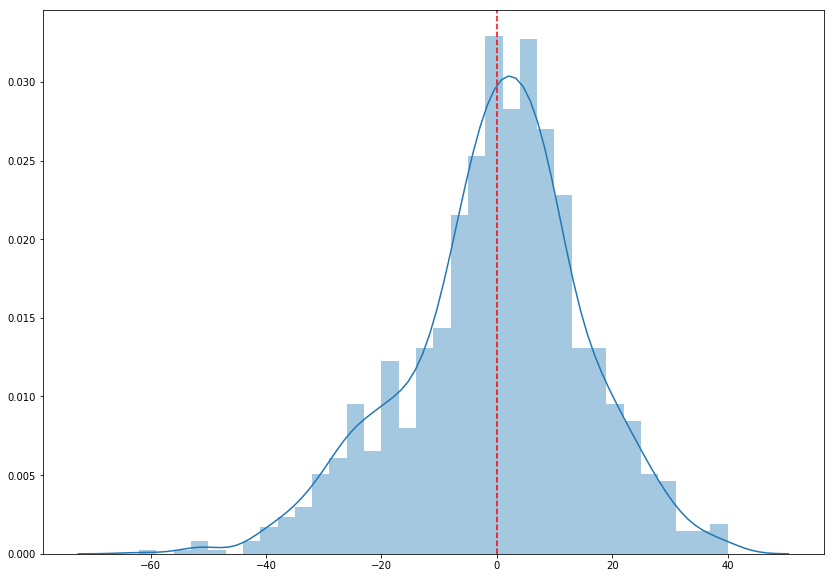

In [19]:
n = 7
has_both = county_all[(np.sum(county_all.iloc[:, 95:205], axis=1) > 0) & (np.sum(county_all.iloc[:, 205:], axis=1) > 0)]
has_cases = county_all[(np.sum(county_all.iloc[:, 95:205], axis=1) > 0) | (np.sum(county_all.iloc[:, 205:], axis=1) > 0)]
deltas = (find_peak(has_both, stat='deaths', smoothness=n) -
          find_peak(has_both, stat='cases', smoothness=n)).days
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)
ax.axvline(0, color='red', linestyle='--')
sns.distplot(np.array(deltas), kde=True, ax=ax)
print('Median Case/Death Lag:', np.median(deltas))
print('Mean Case/Death Lag:', np.mean(deltas))
plt.show()

In [213]:
def corr(df, var1, var2):
    demean = lambda arr: arr - arr.mean()
    col1, col2 = demean(has_cases[var1]), demean(has_cases[var2])
    return np.sum(col1*col2)/np.sqrt(np.sum(col1**2) * np.sum(col2**2))

for col in has_cases.columns[:94]:
    if has_cases[col].dtype != object and np.count_nonzero(np.isnan(has_cases[col])):    
        var1 = '5/11/20_cases'
        var2 = '5/11/20_deaths'
        print('Column:\t\t\t\t', col)
        print('Correlation with Cases:\t\t', corr(has_cases, col, var1))
        print('Correlation with Deaths:\t', corr(has_cases, col, var2))
        print()

Column:				 lat
Correlation with Cases:		 0.05830320859589626
Correlation with Deaths:	 0.047116483108315364

Column:				 lon
Correlation with Cases:		 0.0796920098038012
Correlation with Deaths:	 0.0696541139762602

Column:				 #EligibleforMedicare2018
Correlation with Cases:		 0.4221216245949625
Correlation with Deaths:	 0.2693671397806436

Column:				 3-YrDiabetes2015-17
Correlation with Cases:		 0.34947783533739535
Correlation with Deaths:	 0.20896489760367026

Column:				 HeartDiseaseMortality
Correlation with Cases:		 -0.07946254886004048
Correlation with Deaths:	 -0.05144352691307668

Column:				 StrokeMortality
Correlation with Cases:		 -0.14903407770011431
Correlation with Deaths:	 -0.11473841758247898

Column:				 dem_to_rep_ratio
Correlation with Cases:		 0.30887422348533733
Correlation with Deaths:	 0.26317174101371177

Column:				 3-YrMortalityAge<1Year2015-17
Correlation with Cases:		 0.2836004514048823
Correlation with Deaths:	 0.15061697157527362

Column:				 3-YrMortal

In [329]:
[col for col in county_all.columns if 'pop' in col.lower()]

['POP_LATITUDE',
 'POP_LONGITUDE',
 'PopulationEstimate2018',
 'PopTotalMale2017',
 'PopTotalFemale2017',
 'PopulationEstimate65+2017',
 'PopulationDensityperSqMile2010',
 'CensusPopulation2010',
 'PopMale<52010',
 'PopFmle<52010',
 'PopMale5-92010',
 'PopFmle5-92010',
 'PopMale10-142010',
 'PopFmle10-142010',
 'PopMale15-192010',
 'PopFmle15-192010',
 'PopMale20-242010',
 'PopFmle20-242010',
 'PopMale25-292010',
 'PopFmle25-292010',
 'PopMale30-342010',
 'PopFmle30-342010',
 'PopMale35-442010',
 'PopFmle35-442010',
 'PopMale45-542010',
 'PopFmle45-542010',
 'PopMale55-592010',
 'PopFmle55-592010',
 'PopMale60-642010',
 'PopFmle60-642010',
 'PopMale65-742010',
 'PopFmle65-742010',
 'PopMale75-842010',
 'PopFmle75-842010',
 'PopMale>842010',
 'PopFmle>842010',
 'HPSAServedPop',
 'HPSAUnderservedPop',
 'Population']

In [229]:
def preprocess(arr, smoothness=7):
    """
    Differentiates and smooths the array, and excludes whatever indices are meant to be excluded.
    """
    return moving_average(np.diff(arr[keep_idxs(arr, 1849)], axis=1), n=smoothness, ndim=2)

county_all_deaths = np.array(county_all.iloc[:, 95:205]) / county_all['PopulationEstimate2018'][:, None]
county_all_deaths = preprocess(county_all_deaths)
county_deaths_centered = county_all_deaths - county_all_deaths.mean(axis=1)[:, None]
county_all_cases = np.array(county_all.iloc[:, 205:]) / county_all['PopulationEstimate2018'][:, None]
county_all_cases = preprocess(county_all_cases)
county_cases_centered = county_all_cases - county_all_cases.mean(axis=1)[:, None]
    
keep_idxs = lambda arr, excl: (np.arange(len(arr)) != excl)

names_nony = (county_all['CountyName'] + ', ' + county_all['StateName']).iloc[keep_idxs(county_all, 1849)]
county_all_nony = county_all[keep_idxs(county_all, 1849)]

In [235]:
print(county_deaths_nony.shape)

(3138, 103)


### Note of data cleaning

We only consider assigned counties, as their time series include far fewer negative jumps, which are seen to be inaccurate.

For PCA we also exclude New York (it gets its own "cluster").

In [60]:
deaths.columns

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_',
       ...
       '5/3/20', '5/4/20', '5/5/20', '5/6/20', '5/7/20', '5/8/20', '5/9/20',
       '5/10/20', '5/11/20', '5/12/20'],
      dtype='object', length=124)

In [225]:
death_nums = np.array(county_all.iloc[:, 95:206])
day_diffs = np.diff(death_nums, axis=1)
negs = np.argwhere(day_diffs < 0)
case_nums = np.array(county_all.iloc[:, 206:])
day_diffs_cases = np.diff(case_nums, axis=1)
negs_cases = np.argwhere(day_diffs_cases < 0)

In [226]:
negs_cases.shape

(2223, 2)

In [228]:
for pair in negs_cases:
    val = day_diffs_cases[pair[0], pair[1]]
    # Only look at changes that aren't that 
    if val < -10:
        print('County Name:', county_all['CountyName'][pair[0]])
        print('Decrease in Number:', val)
        print()

County Name: Cullman
Decrease in Number: -11

County Name: Madison
Decrease in Number: -20

County Name: Tuscaloosa
Decrease in Number: -11

County Name: Sutter
Decrease in Number: -14

County Name: Sutter
Decrease in Number: -16

County Name: Pitkin
Decrease in Number: -14

County Name: Alachua
Decrease in Number: -28

County Name: Bibb
Decrease in Number: -19

County Name: Dougherty
Decrease in Number: -13

County Name: Tazewell
Decrease in Number: -15

County Name: Dearborn
Decrease in Number: -69

County Name: De Kalb
Decrease in Number: -54

County Name: Jasper
Decrease in Number: -13

County Name: Ripley
Decrease in Number: -12

County Name: Jefferson
Decrease in Number: -19

County Name: Lafayette
Decrease in Number: -47

County Name: St Charles
Decrease in Number: -15

County Name: St Landry
Decrease in Number: -23

County Name: Baltimore
Decrease in Number: -18

County Name: Baltimore
Decrease in Number: -26

County Name: St Marys
Decrease in Number: -15

County Name: Jackson


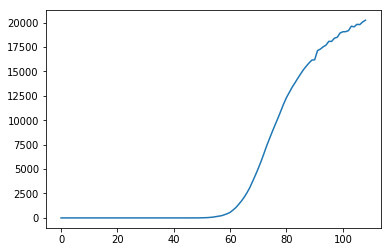

In [63]:
k = 1863
plt.plot(np.arange(len(deaths.iloc[k, 15:])), deaths.iloc[k, 15:])

In [240]:
pca = PCA(n_components=2, whiten=False)
pca.fit(county_all_deaths)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [241]:
p = pca.fit_transform(county_deaths_centered)
px.scatter(p[:, 0], p[:, 1], hover_name=list(names_nony), color=county_all_nony['lat'])

In [25]:
px.scatter(p[:, 0], p[:, 1], hover_name=list(names_nony), color=county_all_nony['lon'])

In [298]:
for col in county_all_cases.columns:
    if county_all_cases[col].dtype != 'int64':
        print(county_all_cases[col].dtype)

In [ ]:
p = pca(county_all_cases, 2)

In [9]:
county_all_cases.shape

(3140, 112)